# (15) CIFAR — mlp

**Motivation**: host = ```mach```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 3
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:3  ———  host: mach

## Poisson 

Dataset: CIFAR10

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('CIFAR10', model_type, 'jacob|mlp')

seq_len = 64
cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len
cfg_vae['n_latents'] = 2000

cfg_tr['kl_beta'] = 4/8 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

tr.n_iters

125000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  14.6 Mil  |
|     ———     |    ———     |
|    layer    |  14.6 Mil  |
+-------------+------------+

poisson_CIFAR10_t-64_z-[2000]_<jacob|mlp>
b80-ep200-lr(0.0001)_beta(32:0x0.1)_temp(0.05:lin-0.5)_gr(2000)_(2024_09_20,11:14)

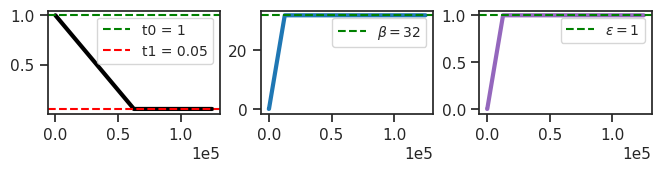

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  14.6 Mil  |
|     ———      |    ———     |
|     dec      |  14.6 Mil  |
+--------------+------------+

In [7]:
vae.layer.n_exp

tensor([271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271,
        271, 271, 271, 271, 271, 271, 271, 271], device='cuda:3',
       dtype=torch.int32)

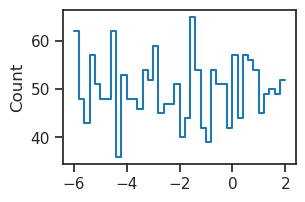

In [8]:
histplot(tonp(vae.layer.log_rate.squeeze()), bins=40);

In [9]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': 2.0, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 64, 'n_latents': [2000], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'mlp', 'dataset': 
'CIFAR10', 'input_sz': (3, 32, 32), 'res_eps': 1.0, 'clamp_u': 6.5, 'clamp_du': 6.0, 'init_dist': 'normal', 
'init_scale': 0.001, 'activation_fn': 'swish', 'fit_prior': True, 'residual': True, 'use_bn': False, 'use_se': 
True, 'track_stats': True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': 
'/home/hadi/Datasets', 'runs_dir': '/home/hadi/Projects/PoissonVAE/runs/poisson_CIFAR10_t-64_z-[2000]_<jacob|mlp>',
'mods_dir': '/home/hadi/Projects/PoissonVAE/models/poisson_CIFAR10_t-64_z-[2000]_<jacob|mlp>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.0001, 'epochs': 200, 'batch_size': 80, 'file_name': None, 'warm_restart': 0, 'warmup_epochs': 1, 
'optimizer': 'adamax_fast', 'optimizer_kws': {'weight_decay': 0.0003, 'betas': (0.9, 0.999), 'eps': 1e-08}, 
'scheduler_type': 'cosine', 'scheduler_kws': {'eta_min': 1e-06, 'T_max': 199.0}, 'ema_rate': None, 'grad_clip': 
2000, 'chkpt_freq': 10, 'eval_freq': 20, 'log_freq': 10, 'method': 'mc', 'kl_beta': 32.0, 'kl_beta_min': 0.0001, 
'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 0.1, 'kl_const_portion':
0.001, 'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 0.05}

### Fit model

In [10]:
tr.train()

epoch # 200, avg loss: 97.319635: 100%|███| 200/200 [15:17:19<00:00, 275.20s/it]


**Task:** lower $\beta$: CIFAR10, ```mlp```, 2000-dim latent space, $(T, \beta) = (64, 32.0)$

In [12]:
print(vae.layer.n_exp)

tensor([27, 29, 30, 34, 38, 44, 49, 53, 57, 59, 61, 62, 62, 63, 63, 63, 63, 63,
        63, 63, 63, 63, 63, 63, 63, 63, 63, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62], device='cuda:3',
       dtype=torch.int32)

In [13]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

u_max.max(), du_max.max()

(6.092774391174316, 6.0)

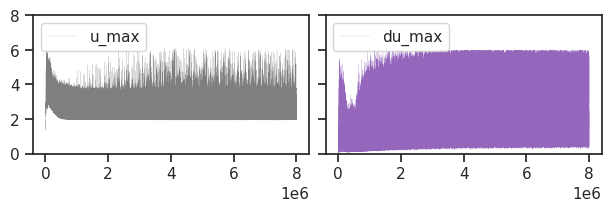

In [14]:
fig, axes = create_figure(1, 2, sharey='row')

axes[0].plot(u_max, color='C7', lw=0.1, label='u_max')
axes[1].plot(du_max, color='C4', lw=0.1, label='du_max')
axes[1].set(ylim=(0, 8))
add_legend(axes)
plt.show()

In [15]:
grad = np.array(list(tr.stats['grad'].values()))
(grad > tr.cfg.grad_clip).sum(), np.round((grad > tr.cfg.grad_clip).mean(), 3)

(1308, 0.01)

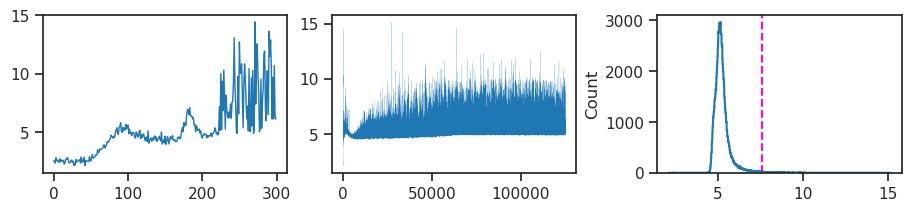

In [16]:
fig, axes = create_figure(1, 3)

axes[0].plot(np.log(grad)[:300], lw=1)
axes[1].plot(np.log(grad), lw=0.1)

axes[2].axvline(np.log(tr.cfg.grad_clip), color='magenta', ls='--')
histplot(np.log(grad), ax=axes[2])

plt.show()

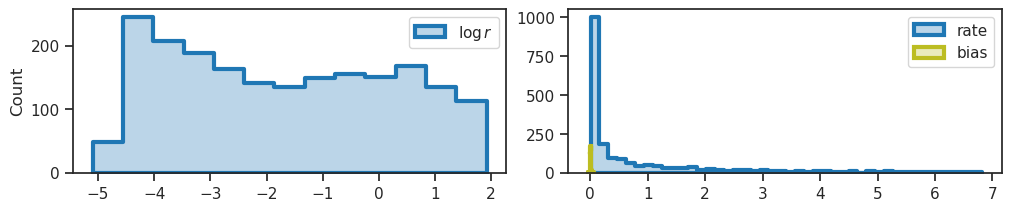

In [17]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [18]:
dead = log_rate > 2
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 2000, 0.0)

100%|█████████████████████████████████| 10/10 [00:36<00:00,  3.66s/it]


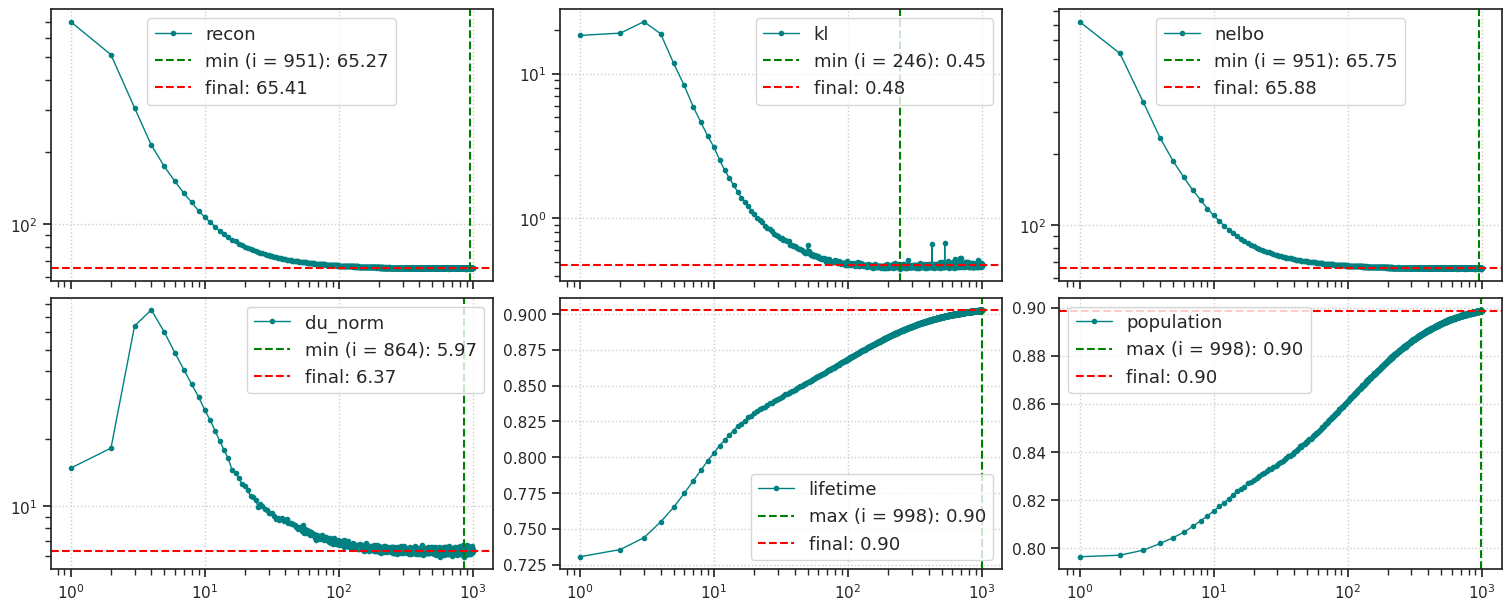

CPU times: user 35.9 s, sys: 3.56 s, total: 39.4 s
Wall time: 39.7 s


In [25]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=100,
    n_data_batches=10,
    active=~dead,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='teal')

In [21]:
kws = dict(
    seq_total=tr.model.cfg.seq_len,
    seq_batch_sz=100,
    n_data_batches=1,
    # active=~dead,
    return_recon=True,
    full_data=True,
    verbose=False,
)
results_to_plot = {
    name: tr.analysis(dl=name, **kws)
    for name in ['trn', 'vld']
}

In [22]:
num = 32

x2p_dict = {}
for name, d in results_to_plot.items():
    x2p = np.concatenate([
        d['x'][:num],
        d['y'][:num, -1].reshape(-1, *tr.model.cfg.input_sz),
    ])
    x2p = (x2p + 1) / 2
    x2p = np.clip(x2p, 0, 1)
    x2p_dict[name] = x2p

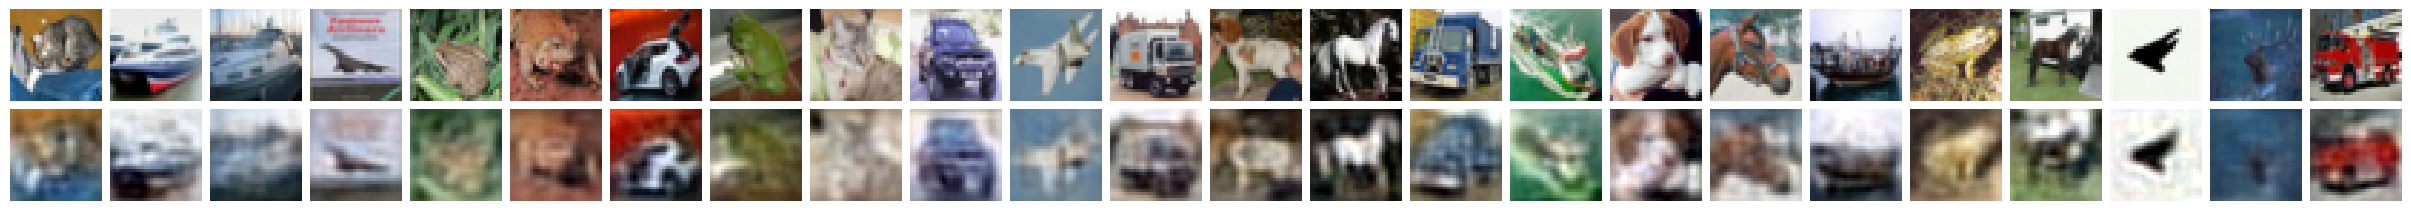

In [23]:
name = 'vld'

fig, axes = create_figure(2, 24, (24, 2))
for i in range(24):
    axes[0, i].imshow(x2p_dict[name][i].transpose(1, 2, 0))
    axes[1, i].imshow(x2p_dict[name][i + 32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

In [ ]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v[:, ~dead].ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()